# Interactively run workflow calcium imaging

+ This notebook walks you through the steps in detail to run the `workflow-calcium-imaging`.  

+ The workflow requires the calcium imaging acquired data from ScanImage or Scanbox and processed data from Suite2p or CaImAn.

+ If you haven't configured the paths, refer to [01-configure](01-configure.ipynb).

+ To overview the schema structures, refer to [02-workflow-structure](02-workflow-structure.ipynb).

+ If you need a more automatic approach to run the workflow, refer to [03-automate](03-automate-optional.ipynb).

Let's change the directory to the package root directory to load the local configuration (`dj_local_conf.json`).

In [1]:
import os
if os.path.basename(os.getcwd()) == "notebooks": os.chdir("..")
import numpy as np

## `Pipeline.py`

+ This script `activates` the DataJoint `elements` and declares other required tables.

In [2]:
import datajoint as dj
from workflow_calcium_imaging.pipeline import *

Connecting user1@127.0.0.1:3306


## Schema diagrams

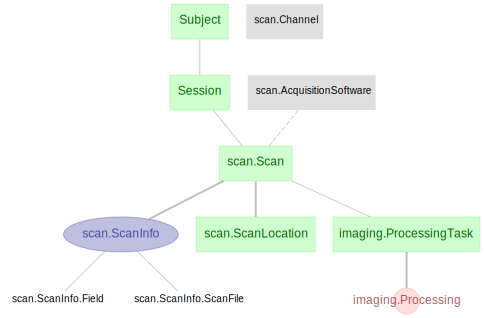

In [3]:
dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + dj.Diagram(scan) + dj.Diagram(imaging.Processing)

## Insert an entry into `subject.Subject`

In [4]:
subject.Subject.heading

# Animal Subject
subject              : varchar(32)                  # 
---
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

In [5]:
subject.Subject.insert1(dict(subject='subject3', 
                             sex='F', 
                             subject_birth_date='2020-01-01', 
                             subject_description='Scanbox acquisition. Suite2p processing.'))

## Insert an entry into `lab.Equipment`

In [6]:
Equipment.insert1(dict(scanner='Scanbox'))

## Insert an entry into `session.Session`

In [7]:
session.Session.describe();

-> Subject
session_datetime     : datetime(3)                  



In [8]:
session.Session.heading

# 
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 

In [9]:
session_key = dict(subject='subject3', session_datetime='2021-04-30 12:22:15.032')

session.Session.insert1(session_key)

session.Session()

subject,session_datetime
subject3,2021-04-30 12:22:15.032000


## Insert an entry into `session.SessionDirectory`

+ The `session_dir` is the relative path to the `imaging_root_data_dir` for the given session, in POSIX format with `/`.

+ Instead of a relative path, `session_dir` could be an absolute path but it is not recommended as the absolute path would have to match the `imaging_root_data_dir` in `dj_local_conf.json`.

In [10]:
session.SessionDirectory.describe();

-> Session
---
session_dir          : varchar(256)                 # Path to the data directory for a particular session



In [11]:
session.SessionDirectory.heading

# 
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 
---
session_dir          : varchar(256)                 # Path to the data directory for a particular session

In [12]:
session.SessionDirectory.insert1(dict(subject='subject3', 
                                      session_datetime='2021-04-30 12:22:15.032', 
                                      session_dir='subject3/210107_run00_orientation_8dir'))

session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a particular session
subject3,2021-04-30 12:22:15.032000,subject3/210107_run00_orientation_8dir


## Insert an entry into `scan.Scan`

In [13]:
scan.Scan.heading

# 
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 
scan_id              : int                          # 
---
scanner              : varchar(32)                  # 
acq_software         : varchar(24)                  # 
scan_notes=""        : varchar(4095)                # free-notes

In [14]:
scan.Scan.insert1(dict(subject='subject3', 
                       session_datetime='2021-04-30 12:22:15.032', 
                       scan_id=0, 
                       scanner='Scanbox', 
                       acq_software='Scanbox',
                       scan_notes=''))
scan.Scan()

subject,session_datetime,scan_id,scanner,acq_software,scan_notes free-notes
subject3,2021-04-30 12:22:15.032000,0,Scanbox,Scanbox,


## Populate `scan.ScanInfo`

+ This imported table stores information about the acquired image (e.g. image dimensions, file paths, etc.).
+ `populate` automatically calls `make` for every key for which the auto-populated table is missing data.
+ `populate_settings` passes arguments to the `populate` method.
+ `display_progress=True` reports the progress bar

In [15]:
scan.ScanInfo.describe();

# general data about the reso/meso scans, from ScanImage header
-> scan.Scan
---
nfields              : tinyint                      # number of fields
nchannels            : tinyint                      # number of channels
ndepths              : int                          # Number of scanning depths (planes)
nframes              : int                          # number of recorded frames
nrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)
x                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
y                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
z                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
fps                  : float                        # (Hz) frames per second - Volumetric Scan Rate
bidirectional        : tinyint                      # true = bidirectio

In [16]:
scan.ScanInfo.heading

# general data about the reso/meso scans, from ScanImage header
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 
scan_id              : int                          # 
---
nfields              : tinyint                      # number of fields
nchannels            : tinyint                      # number of channels
ndepths              : int                          # Number of scanning depths (planes)
nframes              : int                          # number of recorded frames
nrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)
x                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
y                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
z                    : float                        # (um) ScanImage's 0 point in the motor coordinate system
fps                

In [17]:
populate_settings = {'display_progress': True}

In [18]:
scan.ScanInfo.populate(**populate_settings)
scan.ScanInfo()

ScanInfo: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s]{'scanning_mode': 'bidirectional', 'frame_rate': 7.8125, 'num_frames': 7530, 'num_channels': 1, 'num_planes': 4, 'frame_size': array([512, 796], dtype=uint16), 'num_target_frames': 0, 'num_stored_frames': 30123, 'stage_pos': [0, 0, -311.71], 'stage_angle': 9.65, 'etl_pos': [203, 255, 314, 379], 'filename': 'run00_orientation_8dir_000_000.sbx', 'resonant_freq': 8000, 'scanbox_version': 3, 'records_per_buffer': 256, 'magnification': 1.7, 'um_per_pixel_x': nan, 'um_per_pixel_y': nan, 'objective': 'Nikon_16x_dlr', 'messages': array([], dtype=object), 'event_id': array([], dtype=uint8), 'usernotes': array([], dtype='<U1'), 'ballmotion': array([], dtype='<U1')}



subject,session_datetime,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage)
subject3,2021-04-30 12:22:15.032000,0,4,1,4,7530,0,0.0,0.0,-311.71,7.8125,0,nan,nan


## (Optional) Insert a new entry into `imaging.ProcessingParamSet` for Suite2p or CaImAn

+ Define and insert the parameters that will be used for the Suite2p or CaImAn processing.

+ This step is not needed if you are using an existing ProcessingParamSet.

### Define Suite2p parameters

In [19]:
params_suite2p = {'look_one_level_down': 0.0,
                  'fast_disk': [],
                  'delete_bin': False,
                  'mesoscan': False,
                  'h5py': [],
                  'h5py_key': 'data',
                  'save_path0': [],
                  'subfolders': [],
                  'nplanes': 1,
                  'nchannels': 1,
                  'functional_chan': 1,
                  'tau': 1.0,
                  'fs': 10.0,
                  'force_sktiff': False,
                  'preclassify': 0.0,
                  'save_mat': False,
                  'combined': True,
                  'aspect': 1.0,
                  'do_bidiphase': False,
                  'bidiphase': 0.0,
                  'do_registration': True,
                  'keep_movie_raw': False,
                  'nimg_init': 300,
                  'batch_size': 500,
                  'maxregshift': 0.1,
                  'align_by_chan': 1,
                  'reg_tif': False,
                  'reg_tif_chan2': False,
                  'subpixel': 10,
                  'smooth_sigma': 1.15,
                  'th_badframes': 1.0,
                  'pad_fft': False,
                  'nonrigid': True,
                  'block_size': [128, 128],
                  'snr_thresh': 1.2,
                  'maxregshiftNR': 5.0,
                  '1Preg': False,
                  'spatial_hp': 50.0,
                  'pre_smooth': 2.0,
                  'spatial_taper': 50.0,
                  'roidetect': True,
                  'sparse_mode': False,
                  'diameter': 12,
                  'spatial_scale': 0,
                  'connected': True,
                  'nbinned': 5000,
                  'max_iterations': 20,
                  'threshold_scaling': 1.0,
                  'max_overlap': 0.75,
                  'high_pass': 100.0,
                  'inner_neuropil_radius': 2,
                  'min_neuropil_pixels': 350,
                  'allow_overlap': False,
                  'chan2_thres': 0.65,
                  'baseline': 'maximin',
                  'win_baseline': 60.0,
                  'sig_baseline': 10.0,
                  'prctile_baseline': 8.0,
                  'neucoeff': 0.7,
                  'xrange': np.array([0, 0]),
                  'yrange': np.array([0, 0])}

### Insert Suite2p parameters

+ A method of the class `ProcessingParamset` called `insert_new_params` is a helper function to insert the Suite2p or CaIman parameters and ensures that the parameter set inserted is not duplicated.

In [20]:
imaging.ProcessingParamSet.insert_new_params(
    processing_method='suite2p', 
    paramset_idx=0, 
    params=params_suite2p,
    paramset_desc='Calcium imaging analysis with Suite2p using default Suite2p parameters')

## Insert new ProcessingTask to trigger ingestion of motion correction and segmentation results

+ Motion correction and segmentation are performed for each scan in Suite2p or CaImAn.

+ An entry in `ProcessingTask` indicates a set of motion correction and segmentation results (generated from Suite2p or CaImAn outside of `workflow-calcium-imaging`) are ready to be ingested.  In a future release, an entry in `ProcessingTask` can also indicate a new processing job (using Suite2p or CaImAn) is to be triggered.

+ Two pieces of information need to be specified:

    + The `paramset_idx` is the parameter set stored in `imaging.ProcessingParamSet` that is used for the Suite2p or CaImAn processing job.
    
    + The `processing_output_dir` stores the directory of the processing results (relative to the imaging root data directory).

In [21]:
imaging.ProcessingTask.insert1(dict(subject='subject3', 
                                    session_datetime='2021-04-30 12:22:15.032', 
                                    scan_id=0,
                                    paramset_idx=0,
                                    processing_output_dir='subject3/210107_run00_orientation_8dir/suite2p'))

## Populate `imaging.Processing`

In [22]:
imaging.Processing.populate(**populate_settings)

Processing: 100%|██████████| 1/1 [00:00<00:00, 68.04it/s]


## Insert new Curation following the ProcessingTask

+ The next step in the pipeline is the curation of motion corection and segmentation results.

+ If a manual curation was implemented, an entry needs to be manually inserted into the table `imaging.Curation`, which specifies the directory to the curated results in `curation_output_dir`. 

+ If we would like to use the processed outcome directly, an entry is also needed in `imaging.Curation`. A method `create1_from_processing_task` was provided to help this insertion. It copies the `processing_output_dir` in `imaging.ProcessingTask` to the field `curation_output_dir` in the table `imaging.Curation` with a new `curation_id`.

    + In this example, we create/insert one `imaging.Curation` for each `imaging.ProcessingTask`, specifying the same output directory.

    + To this end, we could also make use of a convenient function `imaging.Curation().create1_from_processing_task()`

In [23]:
imaging.Curation.insert1(dict(subject='subject3', 
                              session_datetime='2021-04-30 12:22:15.032', 
                              scan_id=0,
                              paramset_idx=0,
                              curation_id=0,
                              curation_time='2021-04-30 12:22:15.032', 
                              curation_output_dir='subject3/210107_run00_orientation_8dir/suite2p',
                              manual_curation=False,
                              curation_note=''))

## Populate `imaging.MotionCorrection`

+ This table contains the rigid or non-rigid motion correction data including the shifts and summary images.


In [24]:
imaging.MotionCorrection.populate(**populate_settings)

MotionCorrection: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


## Populate `imaging.Segmentation`

+ This table contains the mask coordinates, weights, and centers.

In [25]:
imaging.Segmentation.populate(**populate_settings)

Segmentation: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


## Add another set of results from a new round of curation

If you performed curation on an existing processed results (i.e. motion correction or segmentation) then:
    
+ Add an entry into `imaging.Curation` with the directory of the curated results and a new `curation_id`.

+ Populate the `imaging.MotionCorrection` and `imaging.Segmentation` tables again.

## Populate `imaging.MaskClassification`

+ This table contains the classification of the segmented masks and the confidence of classification.

In [26]:
imaging.MaskClassification.populate(**populate_settings)

MaskClassification: 100%|██████████| 1/1 [00:00<00:00, 385.65it/s]


## Populate `imaging.Fluorescence`

+ This table contains the fluorescence traces prior to filtering and spike extraction.

In [27]:
imaging.Fluorescence.populate(**populate_settings)

Fluorescence: 100%|██████████| 1/1 [00:49<00:00, 49.05s/it]


## Populate `imaging.Activity`
+ This table contains the inferred neural activity from the fluorescence traces.

In [28]:
imaging.Activity.populate(**populate_settings)

Activity: 100%|██████████| 1/1 [00:07<00:00,  7.89s/it]


## Next steps

+ Proceed to the [05-explore](05-explore.ipynb) to learn how to  query, fetch, and visualize the imaging data.